### Load libraries

In [1]:
# Library for data visualisation
import pandas as pd
import numpy as np
from pathlib import Path
import pathlib
import os
from PIL import Image
import numpy as np
import json
from cv2 import cv2
import torch
from torchvision.ops import box_convert
from typing import List, Dict
from skimage.io import imread
import pickle

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch

import torchvision.transforms as T
from cv2 import cv2
import os
import json
import time
import pickle

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')

from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch


## Create a test train folder

In [2]:
import os
import random
import numpy as np
import shutil
from cv2 import cv2
import json
import pathlib
import sys
sys.path.append('../')

#Set path to root dir (wrist folder)
root_dir = '../literature/Other/supervisely/'

# Path to annotation dir
ann_dir = os.listdir(root_dir + 'wrist/ann')

# Path to image dir
img_dir = os.listdir(root_dir + 'wrist/img')



print('Number of annotations: {}'.format(len(ann_dir)))
print('Number of images: {}'.format(len(img_dir)))




Number of annotations: 20274
Number of images: 20274


In [3]:
df = pd.DataFrame(img_dir, columns=["image_name"])
df['annotation_name'] = ann_dir
df['patient_id'] = df['image_name'].apply(lambda x: x.split('_')[0])
df.head()


,image_name,annotation_name,patient_id
0,0001_1297860395_01_WRI-L1_M014.png,0001_1297860395_01_WRI-L1_M014.json,0001
1,0001_1297860435_01_WRI-L2_M014.png,0001_1297860435_01_WRI-L2_M014.json,0001
2,0002_0354485735_01_WRI-R1_F012.png,0002_0354485735_01_WRI-R1_F012.json,0002
3,0002_0354485759_01_WRI-R2_F012.png,0002_0354485759_01_WRI-R2_F012.json,0002
4,0003_0662359226_01_WRI-R1_M011.png,0003_0662359226_01_WRI-R1_M011.json,0003


In [37]:
import pandas as pd
import numpy as np

# shuffle the rows randomly
df = df.sample(frac=1, random_state=42)

# get the unique patient IDs and shuffle them randomly
patient_ids = df['patient_id'].unique()
np.random.shuffle(patient_ids)

# calculate the number of patients for each split
n_patients = len(patient_ids)
n_train_patients = int(np.ceil(0.75 * n_patients))
n_test_patients = int(np.ceil(0.15 * n_patients))
n_val_patients = n_patients - n_train_patients - n_test_patients

# split the patient IDs into train, test, and val sets
train_patients = patient_ids[:n_train_patients]
test_patients = patient_ids[n_train_patients:n_train_patients+n_test_patients]
val_patients = patient_ids[n_train_patients+n_test_patients:]

# assign each image/annotation pair to a split based on its patient ID
train_df = df[df['patient_id'].isin(train_patients)]
test_df = df[df['patient_id'].isin(test_patients)]
val_df = df[df['patient_id'].isin(val_patients)]

# drop the patient ID column from the split dataframes
train_df = train_df.drop('patient_id', axis=1)
test_df = test_df.drop('patient_id', axis=1)
val_df = val_df.drop('patient_id', axis=1)

# set the train, test, and val columns to True for the appropriate dataframes
train_df['train'] = True
train_df['test'] = False
train_df['val'] = False
test_df['train'] = False
test_df['test'] = True
test_df['val'] = False
val_df['train'] = False
val_df['test'] = False
val_df['val'] = True

# concatenate the split dataframes back into a single dataframe
df_split = pd.concat([train_df, test_df, val_df], axis=0)

# reset the index of the concatenated dataframe
df_split = df_split.reset_index(drop=True)


In [4]:
df_split

NameError: name 'df_split' is not defined

In [39]:
# print the lengths of the three lists
print("Number of image/annotation pairs for training:", (df_split['train'] == True).sum())
print("Number of image/annotation pairs for testing:", (df_split['test'] == True).sum())
print("Number of image/annotation pairs for validation:", (df_split['val'] == True).sum())

Number of image/annotation pairs for training: 15212
Number of image/annotation pairs for testing: 3022
Number of image/annotation pairs for validation: 2040


In [41]:
df_split['patient_id'] = df_split['image_name'].apply(lambda x: x.split('_')[0])
df_split.head(20)

,image_name,annotation_name,train,test,val,patient_id
0,3675_0468236894_01_WRI-L1_F011.png,3675_0468236894_01_WRI-L1_F011.json,True,False,False,3675
1,4120_1207781914_03_WRI-R2_F011.png,4120_1207781914_03_WRI-R2_F011.json,True,False,False,4120
2,4561_0305364951_01_WRI-L1_M009.png,4561_0305364951_01_WRI-L1_M009.json,True,False,False,4561
3,1533_0711733814_03_WRI-R1_M013.png,1533_0711733814_03_WRI-R1_M013.json,True,False,False,1533
4,3492_0109706373_01_WRI-R1_M008.png,3492_0109706373_01_WRI-R1_M008.json,True,False,False,3492
5,4072_0380372957_03_WRI-L2_M006.png,4072_0380372957_03_WRI-L2_M006.json,True,False,False,4072
6,1061_0548215464_03_WRI-R2_F009.png,1061_0548215464_03_WRI-R2_F009.json,True,False,False,1061
7,5284_0448960777_01_WRI-L2_F011.png,5284_0448960777_01_WRI-L2_F011.json,True,False,False,5284
8,4296_0530028137_03_WRI-L1_M014.png,4296_0530028137_03_WRI-L1_M014.json,True,False,False,4296
9,2056_0500102100_01_WRI-L1_M009.png,2056_0500102100_01_WRI-L1_M009.json,True,False,False,2056


In [43]:
# Group the dataset by patient ID
grouped = df_split.groupby('patient_id')

# Iterate over each group and check if the unique values in the train, test, and val columns are all the same
for name, group in grouped:
    train_vals = set(group['train'].unique())
    test_vals = set(group['test'].unique())
    val_vals = set(group['val'].unique())
    if len(train_vals) > 1 or len(test_vals) > 1 or len(val_vals) > 1:
        print(f"Patient ID {name} has inconsistent values for train, test, or val.")


In [49]:
sorted_df = df_split.sort_values(by='patient_id').reset_index(drop=True)

In [53]:
sorted_df.head(50)

,image_name,annotation_name,train,test,val,patient_id
0,0001_1297860395_01_WRI-L1_M014.png,0001_1297860395_01_WRI-L1_M014.json,True,False,False,0001
1,0001_1297860435_01_WRI-L2_M014.png,0001_1297860435_01_WRI-L2_M014.json,True,False,False,0001
2,0002_0354485759_01_WRI-R2_F012.png,0002_0354485759_01_WRI-R2_F012.json,True,False,False,0002
3,0002_0354485735_01_WRI-R1_F012.png,0002_0354485735_01_WRI-R1_F012.json,True,False,False,0002
4,0003_0663715782_02_WRI-R2_M011.png,0003_0663715782_02_WRI-R2_M011.json,True,False,False,0003
5,0003_0662359226_01_WRI-R1_M011.png,0003_0662359226_01_WRI-R1_M011.json,True,False,False,0003
6,0003_0664918633_03_WRI-R1_M011.png,0003_0664918633_03_WRI-R1_M011.json,True,False,False,0003
7,0003_0663715732_02_WRI-R1_M011.png,0003_0663715732_02_WRI-R1_M011.json,True,False,False,0003
8,0003_0664918693_03_WRI-R2_M011.png,0003_0664918693_03_WRI-R2_M011.json,True,False,False,0003
9,0003_0662359351_01_WRI-R2_M011.png,0003_0662359351_01_WRI-R2_M011.json,True,False,False,0003


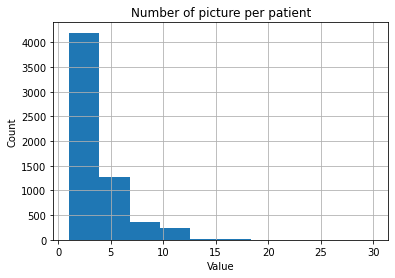

In [61]:
import matplotlib.pyplot as plt
# count the occurrences of each value in column A
counts = sorted_df['patient_id'].value_counts()

# create a histogram of the counts
counts.hist(bins=10)

# set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Number of picture per patient')

# show the plot
plt.show()

In [59]:
counts.value_counts().unique()

array([4041,  777,  469,  326,  161,  117,   60,   36,   23,   19,   15,
         11,   10,    8,    3,    2,    1], dtype=int64)

In [56]:
sorted_df[sorted_df['patient_id'] == '0560']

,image_name,annotation_name,train,test,val,patient_id
1845,0560_0424420718_05_WRI-R1_M007.png,0560_0424420718_05_WRI-R1_M007.json,True,False,False,0560
1846,0560_0423122272_01_WRI-L2_M007.png,0560_0423122272_01_WRI-L2_M007.json,True,False,False,0560
1847,0560_0423812960_02_WRI-L1_M007.png,0560_0423812960_02_WRI-L1_M007.json,True,False,False,0560
1848,0560_0425029609_06_WRI-R1_M007.png,0560_0425029609_06_WRI-R1_M007.json,True,False,False,0560
1849,0560_0423122214_01_WRI-L1_M007.png,0560_0423122214_01_WRI-L1_M007.json,True,False,False,0560
1850,0560_0425632927_07_WRI-L1_M007.png,0560_0425632927_07_WRI-L1_M007.json,True,False,False,0560
1851,0560_0426749638_09_WRI-L2_M007.png,0560_0426749638_09_WRI-L2_M007.json,True,False,False,0560
1852,0560_0425029820_06_WRI-R2_M007.png,0560_0425029820_06_WRI-R2_M007.json,True,False,False,0560
1853,0560_0425632906_07_WRI-R2_M007.png,0560_0425632906_07_WRI-R2_M007.json,True,False,False,0560
1854,0560_0424420824_05_WRI-R2_M007.png,0560_0424420824_05_WRI-R2_M007.json,True,False,False,0560


In [60]:
counts.head()

0560    30
0313    26
1009    24
4089    22
4672    22
Name: patient_id, dtype: int64

In [8]:
#os.chdir('../')

print("The working directory of this project is:", os.getcwd())

The working directory of this project is: c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


## Save images as RPG

In [63]:
os.mkdir("../literature/Other/supervisely/wrist/rpg_images")

In [64]:
from tqdm import tqdm
root_dir = pathlib.Path('../literature/Other/supervisely/wrist/img/')


for idx in tqdm(range(len(img_dir))):
    img_path = os.path.join(root_dir,img_dir[idx])
    ann_path = os.path.join('../literature/Other/supervisely/wrist/ann/',ann_dir[idx])


    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Convert the grayscale image to RGB and duplicate the grayscale channel
    img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB) 
    cv2.imwrite("../literature/Other/supervisely/wrist/rpg_images/" +img_dir[idx] , img)


100%|██████████| 20274/20274 [22:09<00:00, 15.25it/s] 


## Create the pickles


In [92]:
from tqdm import tqdm
def data_fix(img_list,ann_list):

    root_dir = pathlib.Path('../literature/Other/supervisely')

    for idx in tqdm(range(len(img_list))):
        img_path = os.path.join(img_list[idx])
        ann_path = os.path.join(ann_list[idx])
        
        #target = []
        d = {}

        box = []
        boxes = []
        labels = []
        area = []

        classes = {'fracture' : 1, 'text' : 2}


        name = pathlib.PurePath(ann_path).name.split('.')[0]

        

        with open(ann_path) as json_file:
            
            #Load the JSON file
            data = json.load(json_file)


        for object_dict in data['objects']:
    
            # Check if object contains any fractures

            if object_dict['classTitle'] == "text" or object_dict['classTitle'] == "fracture":

                # Get points and convert them to int for display purposes
                top_left_point, bottom_right_point = object_dict['points']['exterior']
                top_left_point = list(map(int,top_left_point))
                bottom_right_point = list(map(int, bottom_right_point))
                box = (top_left_point+bottom_right_point)
                area.append((box[3] - box[1]) * (box[2] - box[0]))
                label = classes[object_dict['classTitle']]
                labels.append(label)
                boxes.append(box)

                # Check if the list is empty
                if len(box) == 0:
                    print("The list is empty!")
                

        boxes = torch.FloatTensor(boxes)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)

        image_id = torch.tensor([idx])
                
        
        d["boxes"] = boxes
        d["labels"] = labels
        d["image_id"] = image_id
        d["area"] = area
        

        target = d

        img = img_path

        ready_data = {'image' : img,'target' : target}


        path = os.path.join(root_dir,'wrist','train_pickles_new', name + '.pickle')

        with open(path, 'wb') as handle:
            pickle.dump(ready_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')

# Path to annotation dir
ann_dir = pathlib.Path(root_dir, 'wrist/ann')

# Path to image dir
img_dir = pathlib.Path(root_dir, 'wrist/rpg_images')

# Lists
list_files = lambda start_dir: [str(item) for item in start_dir.iterdir()]
ann_list = list_files(ann_dir)
img_list = list_files(img_dir)

print('Number of annotations: {}'.format(len(ann_list)))
print('Number of images: {}'.format(len(img_list)))

Number of annotations: 20274
Number of images: 20274


In [64]:
img_dir

WindowsPath('../literature/Other/supervisely/wrist/rpg_images')

In [65]:
img_list

['..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860435_01_WRI-L2_M014.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0002_0354485735_01_WRI-R1_F012.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0002_0354485759_01_WRI-R2_F012.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0662359226_01_WRI-R1_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0662359351_01_WRI-R2_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0663715732_02_WRI-R1_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0663715782_02_WRI-R2_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0664918633_03_WRI-R1_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0664918693_03_WRI-R2_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\000

# New dataset


In [93]:
# define the path to the directory containing the images
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')

# Path to annotation dir
ann_dir = pathlib.Path(root_dir, 'wrist/ann')

# Path to image dir
image_dir = pathlib.Path(root_dir, 'wrist/rpg_images')


# define the list of image filenames
image_names =  sorted_df.loc[sorted_df['train'], 'image_name'].tolist()
anno_names = sorted_df.loc[sorted_df['train'], 'annotation_name'].tolist()

# create a list of the full file paths by joining the image_dir and image_names
image_paths = [os.path.join(image_dir, name) for name in image_names]
anno_paths = [os.path.join(ann_dir, name) for name in anno_names]

In [94]:
anno_paths

['..\\literature\\Other\\supervisely\\wrist\\ann\\0001_1297860395_01_WRI-L1_M014.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0001_1297860435_01_WRI-L2_M014.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0002_0354485759_01_WRI-R2_F012.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0002_0354485735_01_WRI-R1_F012.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0003_0663715782_02_WRI-R2_M011.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0003_0662359226_01_WRI-R1_M011.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0003_0664918633_03_WRI-R1_M011.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0003_0663715732_02_WRI-R1_M011.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0003_0664918693_03_WRI-R2_M011.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0003_0662359351_01_WRI-R2_M011.json',
 '..\\literature\\Other\\supervisely\\wrist\\ann\\0004_0542630513_01_WRI-L2_M003.json',
 '..\\literature\\Other\\supervi

In [95]:
image_paths

['..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860435_01_WRI-L2_M014.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0002_0354485759_01_WRI-R2_F012.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0002_0354485735_01_WRI-R1_F012.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0663715782_02_WRI-R2_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0662359226_01_WRI-R1_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0664918633_03_WRI-R1_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0663715732_02_WRI-R1_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0664918693_03_WRI-R2_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0003_0662359351_01_WRI-R2_M011.png',
 '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\000

In [96]:
data_fix(image_paths,anno_paths)

100%|██████████| 15212/15212 [01:41<00:00, 150.14it/s]


In [97]:
print(len(os.listdir('../literature/Other/supervisely/wrist/train_pickles_new')))
print(len(os.listdir('../literature/Other/supervisely/wrist/validation_pickles_new')))
print(len(os.listdir('../literature/Other/supervisely/wrist/test_pickles_new')))

15212
2040
3022


## Create train-test folders 


In [70]:
os.mkdir("../literature/Other/supervisely/wrist/validation_pickles")
os.mkdir("../literature/Other/supervisely/wrist/test_pickles")

In [71]:
#MOVE THE TEST PICKLES TO ANOTHER FOLDER
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')
pickles = pathlib.Path(root_dir, 'wrist/train_pickles')
pickle_list = os.listdir(pickles)


random.seed(1234)
test_images = random.sample(pickle_list, 3000)


for pickle in test_images:
    shutil.move('../literature/Other/supervisely/wrist/train_pickles/'+pickle, '../literature/Other/supervisely/wrist/test_pickles/'+pickle)

In [72]:
#MOVE SOME IMAGES FOR VALIDATION
root_dir = pathlib.Path('../literature/Other/supervisely')
pickles = pathlib.Path(root_dir, 'wrist/train_pickles')
pickle_list = os.listdir(pickles)
validation_images = random.sample(pickle_list, 1000)

for pickle in validation_images:
    shutil.move('../literature/Other/supervisely/wrist/train_pickles/'+pickle, '../literature/Other/supervisely/wrist/validation_pickles/'+pickle)

In [73]:
print(len(os.listdir('../literature/Other/supervisely/wrist/train_pickles')))
print(len(os.listdir('../literature/Other/supervisely/wrist/validation_pickles')))
print(len(os.listdir('../literature/Other/supervisely/wrist/test_pickles')))

16274
1000
3000


## Fix the DETR dataset


In [98]:
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')

# Path to annotation dir
ann_dir = pathlib.Path(root_dir, 'wrist/ann')

# Path to image dir
img_dir = pathlib.Path(root_dir, 'wrist/rpg_images')

# Lists
list_files = lambda start_dir: [str(item) for item in start_dir.iterdir()]
ann_list = list_files(ann_dir)
img_list = list_files(img_dir)
print('Number of annotations: {}'.format(len(ann_list)))
print('Number of annotations: {}'.format(len(img_list)))

Number of annotations: 20274
Number of annotations: 20274


In [99]:
ann_dir

WindowsPath('../literature/Other/supervisely/wrist/ann')

In [100]:
import random


# combine the two lists into a list of tuples
image_annotation_pairs = list(zip(img_list, ann_list))

# shuffle the list of image and annotation pairs randomly
random.shuffle(image_annotation_pairs)

# calculate the length of the shuffled image and annotation pairs list
n = len(image_annotation_pairs)

# calculate the split points for the three lists
train_split = int(0.75 * n)  # 75% for training
test_split = int(0.15 * n)  # 15% for testing
val_split = n - train_split - test_split  # remaining 5% for validation

# split the shuffled image and annotation pairs list into three separate lists
train_pairs = image_annotation_pairs[:train_split]
test_pairs = image_annotation_pairs[train_split:train_split+test_split]
val_pairs = image_annotation_pairs[train_split+test_split:]

# unzip the pairs into separate lists of images and annotations
train_images, train_annotations = zip(*train_pairs)
test_images, test_annotations = zip(*test_pairs)
val_images, val_annotations = zip(*val_pairs)

# print the lengths of the three lists
print("Number of image/annotation pairs for training:", len(train_pairs))
print("Number of image/annotation pairs for testing:", len(test_pairs))
print("Number of image/annotation pairs for validation:", len(val_pairs))


Number of image/annotation pairs for training: 15205
Number of image/annotation pairs for testing: 3041
Number of image/annotation pairs for validation: 2028


In [102]:
# define the list of image filenames
image_names_train =  sorted_df.loc[sorted_df['train'], 'image_name'].tolist()
anno_names_train = sorted_df.loc[sorted_df['train'], 'annotation_name'].tolist()

# create a list of the full file paths by joining the image_dir and image_names
image_paths_train = [os.path.join(image_dir, name) for name in image_names_train]
anno_paths_train = [os.path.join(ann_dir, name) for name in anno_names_train]

# define the list of image filenames
image_names_test =  sorted_df.loc[sorted_df['test'], 'image_name'].tolist()
anno_names_test = sorted_df.loc[sorted_df['test'], 'annotation_name'].tolist()

# create a list of the full file paths by joining the image_dir and image_names
image_paths_test = [os.path.join(image_dir, name) for name in image_names_test]
anno_paths_test = [os.path.join(ann_dir, name) for name in anno_names_test]

# define the list of image filenames
image_names_val =  sorted_df.loc[sorted_df['val'], 'image_name'].tolist()
anno_names_val = sorted_df.loc[sorted_df['val'], 'annotation_name'].tolist()

# create a list of the full file paths by joining the image_dir and image_names
image_paths_val= [os.path.join(image_dir, name) for name in image_names_val]
anno_paths_val = [os.path.join(ann_dir, name) for name in anno_names_val]

In [103]:
from src.models.utils import create_COCO_from_dataset

create_COCO_from_dataset(image_paths_train, anno_paths_train,"train")
create_COCO_from_dataset(image_paths_test, anno_paths_test,"test")
create_COCO_from_dataset(image_paths_val, anno_paths_val,"val")

100%|██████████| 2040/2040 [01:15<00:00, 27.03it/s]


{'info': {'description': 'My dataset in COCO format',
  'url': 'nan',
  'version': '1.0',
  'year': 2023,
  'contributor': 'Spyros Vlachospyros',
  'date_created': '2023-03-02'},
 'licenses': [{'id': 1,
   'name': 'CC-BY-4.0',
   'url': 'https://creativecommons.org/licenses/by/4.0/'}],
 'categories': [{'id': 0, 'name': 'text'}, {'id': 1, 'name': 'fracture'}],
 'images': [{'id': 1,
   'file_name': '../literature/Other/supervisely/wrist/rpg_images/0015_0668695209_01_WRI-L2_F008.png',
   'width': 516,
   'height': 1052},
  {'id': 2,
   'file_name': '../literature/Other/supervisely/wrist/rpg_images/0015_0668695173_01_WRI-L1_F008.png',
   'width': 545,
   'height': 1076},
  {'id': 3,
   'file_name': '../literature/Other/supervisely/wrist/rpg_images/0037_0894273521_01_WRI-R2_M015.png',
   'width': 550,
   'height': 1162},
  {'id': 4,
   'file_name': '../literature/Other/supervisely/wrist/rpg_images/0037_0894273489_01_WRI-R1_M015.png',
   'width': 660,
   'height': 1171},
  {'id': 5,
   'file

## Fix the validation set of CNN to a COCO fromat


In [2]:
%cd ..

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


In [4]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from src.data.my_rpg_dataset import XRayDataSet_coco
from src.data.my_rpg_dataset import collate_fn


In [7]:
%cd notebooks

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [7]:
# Create a dictionary to hold the converted annotations
coco_annotations = {
    'images': [],
    'annotations': [],
    'categories': [{'id': 1, 'name': 'fracture'}, {'id': 2, 'name': 'text'}]
}

#load test data
test_dataset = XRayDataSet_coco(pathlib.Path('../literature/Other/supervisely/wrist/validation_pickles_mix'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4,collate_fn=collate_fn)


# Convert your annotations to COCO format
for i, (img_path, targets) in enumerate(test_dataset):
        
        
    file_name = img_path
        

    # Load the image using cv2
    image = cv2.imread(img_path)

    # Get the height and width of the image
    height, width, channels = image.shape

    coco_annotations['images'].append({
        'id': int(targets['image_id'].cpu().numpy()[0]),
        'file_name': file_name.replace("\\","/").replace('../', ''),
        'height': height,
        'width': width
    })
    for j in range(len(targets['boxes'])):
        #turn boxex from xmin,ymin,xmax,ymax format to coco format x,y,w,h
        box = targets['boxes'][j]
        x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1] 
        area = (box[3] - box[1]) * (box[2] - box[0])
        coco_annotations['annotations'].append({
            'id': len(coco_annotations['annotations']) + 1,
            'image_id': int(targets['image_id'].cpu().numpy()[0]),
            'category_id': targets['labels'][j].item(),
            'bbox': [x.item(), y.item(), w.item(), h.item()],
            'area': area.item(),
            'iscrowd': 0  # Assuming all instances are not crowd
        })

# Create a COCO object for your annotations
coco_gt = COCO()
coco_gt.dataset = coco_annotations
coco_gt.createIndex()

creating index...
index created!


In [6]:
# Save the COCO object to a JSON file
with open('coco_gt_multiview.json', 'w') as f:
    json.dump(coco_gt.dataset, f)

In [12]:
# Load the COCO object from a JSON file
with open('coco_gt.json', 'r') as f:
    coco_gt_data = json.load(f)
coco_gt = COCO()
coco_gt.dataset = coco_gt_data
coco_gt.createIndex()

creating index...
index created!
